# **FinQuery: Intelligent Banking Intent Classification for Customer Support**

# BUSINESS UNDERSTANDING

- I aim to build a robust intent-classification model for BANKING77, which contains 77 fine-grained customer banking service intents.
- This will help automated customer support route queries correctly, improving response time and customer satisfaction.

# DATA UNDERSTANDING

- Train set: 10,003 examples
- Test set:  3,080 examples
- Number of Intents: 77
- Data Source: https://huggingface.co/datasets/PolyAI/banking77

# PROJECT AIM

- Accurately classify user queries into one of 77 intents

In [2]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

%matplotlib inline

In [3]:
# Creating Dataframe from the training Dataset
# Load the training dataset

train_df = pd.read_csv("train.csv")
train_df.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [4]:
# Examining the Data

print(f"The Training Data Shape is: {train_df.shape}")

The Training Data Shape is: (10003, 2)


- Our Training data has 10,003 records and 2 columns

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10003 non-null  object
 1   category  10003 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


- The datatype of the data in both columns i.e., text and category is string i.e, text

In [6]:
# Checking out the missing data

train_df.isna().sum()

text        0
category    0
dtype: int64

In [7]:
# Checking out for duplicates

len(train_df[train_df.duplicated(keep="first")])

0

- There is neither missing data nor duplicates i.e., our data is pretty much clean

## **Exploratory Data Analysis**

### **Distribution of Intent category**

In [9]:
# Counting top 10 distribution of intent category

category_counts = train_df['category'].value_counts().sort_values(ascending=False).head(10)
category_counts

category
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
transaction_charged_twice                           175
declined_cash_withdrawal                            173
transfer_fee_charged                                172
balance_not_updated_after_bank_transfer             171
transfer_not_received_by_recipient                  171
Name: count, dtype: int64

#### **Visualize category distribution**

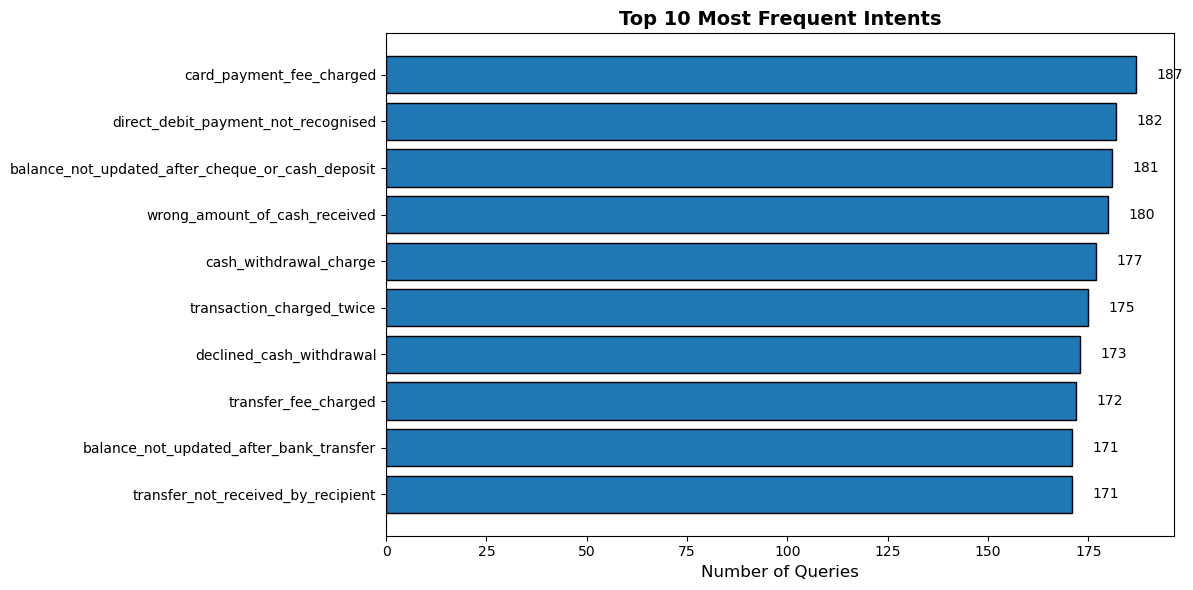

In [11]:
# Intent categories by frequency

plt.figure(figsize=(12, 6))
bars = plt.barh(category_counts.index, category_counts.values, edgecolor='black')
plt.gca().invert_yaxis()  # Highest counts on top
plt.xlabel("Number of Queries", fontsize=12)
plt.title("Top 10 Most Frequent Intents", fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# Annotate each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height() / 2,
             f'{int(width)}', va='center', fontsize=10)
plt.tight_layout()
plt.show();

#### **WordCloud of full training text**

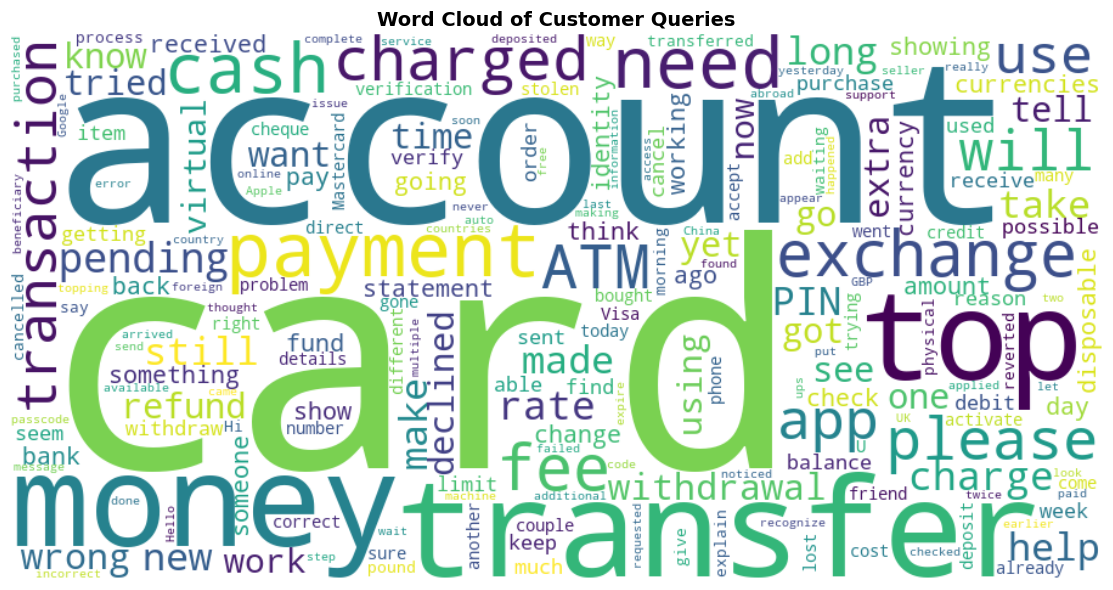

In [12]:
all_text = " ".join(train_df['text'].tolist())
wordcloud = WordCloud(
    width=900,
    height=450,
    background_color='white',
    max_words=200,
    collocations=False
).generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Customer Queries", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show();

## **Data Preprocessing**